# Predicting Customer Churn
For an entreprise, retaining a customer is cheaper than finding a new one, thus having a better understanding on why people churn and what variables make them more likely to leave is vital for the success of a company

### Objective
The purpose of this project is to predict customer churn based on different explanatory variables such as consumed services and demographics.

### Performance
To do so, a classification model will be built and tuned in order to minimise the error of prediction. The performance will be measured by:
* accuracy: % of good estimations 
* recall: % of positives outcomes correctly identified (TP / (TP+FN) )
* precision: % of positive predictions that are actually correct (TP / (TP+FP) )
* f1-score: harmonic mean of precision and recall

For this task, the most important is to identify as much customers likely to leave the company as possible, i.e. have a good recall. However, if all customers were identified like likely to leave, recall would be very high but precision would probably be very low as there would be many false positives. For this reason, it is important to get a high recall, but also a high precision (and therefore, a good f1-score). 

===================================================================================================

# Feature Engineering
===================================================================================================

# Import libraries

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# for Splitting train/test sets
from sklearn.model_selection import train_test_split

# for handling outliers
from feature_engine.outliers import Winsorizer

# For dealing with imbalanced data
from imblearn.over_sampling import SMOTE

# for one-hot encoding categorical variables
from feature_engine.encoding import OneHotEncoder

# for dropping highly correlated features (sp. after onehotencoding)
from feature_engine.selection import DropCorrelatedFeatures

# for scaling
from sklearn.preprocessing import RobustScaler


# to display all the columns of the dataframe in the notebook & all float numbers rounded to 2digits
pd.pandas.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

# Load & Split data

In [2]:
data_dict = raw_data = pd.read_excel('E Commerce Dataset.xlsx', sheet_name = 0)
raw_data = pd.read_excel('E Commerce Dataset.xlsx', sheet_name = 1)
raw_data.head(3)

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.00,Mobile Phone,3,6.00,Debit Card,Female,3.00,3,Laptop & Accessory,2,Single,9,1,11.00,1.00,1.00,5.00,159.93
1,50002,1,NaN,Phone,1,8.00,UPI,Male,3.00,4,Mobile,3,Single,7,1,15.00,0.00,1.00,0.00,120.90
2,50003,1,NaN,Phone,1,30.00,Debit Card,Male,2.00,4,Mobile,3,Single,6,1,14.00,0.00,1.00,3.00,120.28


In [3]:
#Remove first column = ID 
data = raw_data.iloc[:,1:] 

# Splitting into train & test sets to avoid data leakage
train_set, test_set = train_test_split(data, test_size = 0.2, random_state = 42) 

In [4]:
print(f'The train set contains {train_set.shape[0]} rows and {train_set.shape[1]} columns.')
print(f'The test set contains {test_set.shape[0]} rows and {test_set.shape[1]} columns.')

The train set contains 4504 rows and 19 columns.
The test set contains 1126 rows and 19 columns.


In [5]:
# Separating target from features
X_train = train_set.drop(['Churn'], axis=1) # predictive variables
y_train = train_set[['Churn']] # target

X_train.shape, y_train.shape

((4504, 18), (4504, 1))

===================================================================================================
# Analysis

# Variable types (categorical, numerical)

In [6]:
# Identifying categorical & numerical variables 
cat_vars = [var for var in X_train.columns if X_train[var].dtype == 'O']
num_vars = [var for var in X_train.columns if var not in cat_vars]

# Missing data

In [7]:
# Gathering all variables containing missing values
num_with_nan = [var for var in num_vars if X_train[var].isnull().sum() > 0]

# replace missing values with mean 
# (as the % of missing values is near 0, creating a missing indicator would probably not have any impact on the final model)
for var in num_with_nan:
    # calculate the mean 
    mean_val = X_train[var].mean()
    print(var, 'mean :', round(mean_val, 2))
    
    # add binary missing indicator 
    X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
        
    # replace missing values by the mean
    X_train[var].fillna(mean_val, inplace=True)

Tenure mean : 10.2
WarehouseToHome mean : 15.69
HourSpendOnApp mean : 2.93
OrderAmountHikeFromlastYear mean : 15.74
CouponUsed mean : 1.77
OrderCount mean : 3.03
DaySinceLastOrder mean : 4.51


In [8]:
# check that there are no more missing values
X_train[num_with_nan].isnull().sum()

Tenure                         0
WarehouseToHome                0
HourSpendOnApp                 0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
dtype: int64

In [9]:
# check the binary missing indicator variables
missing_indicator_vars = [var for var in X_train.columns if '_na' in var]
X_train[missing_indicator_vars].head()

,Tenure_na,WarehouseToHome_na,HourSpendOnApp_na,OrderAmountHikeFromlastYear_na,CouponUsed_na,OrderCount_na,DaySinceLastOrder_na
4478,0,0,0,0,0,0,0
3685,0,0,0,0,0,0,0
731,0,0,1,0,0,0,0
291,1,0,0,0,0,0,0
184,0,0,0,0,0,0,0


# Numerical variables

## WarehouseToHome - LogTransformation & Handling outliers

In [10]:
var = 'WarehouseToHome'

In [11]:
# Handling outliers
win = Winsorizer(capping_method = 'gaussian',  variables = var)

In [12]:
win.fit(X_train)
X_train = win.transform(X_train)

In [13]:
# Apply log-transformation to Kms as it was the only feature that seemed to benefit from such transformation
X_train[f'{var}'] = np.log(X_train[f'{var}'])

# Categorical variables

### Fixing "PreferredPaymentMode"

In [14]:
X_train.PreferredPaymentMode.value_counts()

Debit Card          1845
Credit Card         1188
E wallet             488
UPI                  336
COD                  298
CC                   227
Cash on Delivery     122
Name: PreferredPaymentMode, dtype: int64

In [15]:
payment_dict = {'CC':'Credit Card', 'COD':'Cash on Delivery'}
X_train.PreferredPaymentMode.replace(payment_dict).value_counts()

Debit Card          1845
Credit Card         1415
E wallet             488
Cash on Delivery     420
UPI                  336
Name: PreferredPaymentMode, dtype: int64

In [16]:
X_train.PreferredPaymentMode = X_train.PreferredPaymentMode.replace(payment_dict)

### Fixing "PreferredLoginDevice"

In [17]:
X_train.PreferredLoginDevice.value_counts()

Mobile Phone    2209
Computer        1313
Phone            982
Name: PreferredLoginDevice, dtype: int64

In [18]:
login_dict = {'Phone':'Mobile Phone'}
X_train.PreferredLoginDevice.replace(login_dict).value_counts()

Mobile Phone    3191
Computer        1313
Name: PreferredLoginDevice, dtype: int64

In [19]:
X_train.PreferredLoginDevice = X_train.PreferredLoginDevice.replace(login_dict)

### Fixing "PreferedOrderCat"

In [20]:
X_train.PreferedOrderCat.value_counts()

Laptop & Accessory    1644
Mobile Phone          1025
Mobile                 649
Fashion                643
Grocery                330
Others                 213
Name: PreferedOrderCat, dtype: int64

In [21]:
orderCat_dict = {'Mobile':'Mobile Phone'}
X_train.PreferedOrderCat.replace(orderCat_dict).value_counts()

Mobile Phone          1674
Laptop & Accessory    1644
Fashion                643
Grocery                330
Others                 213
Name: PreferedOrderCat, dtype: int64

In [22]:
X_train.PreferedOrderCat = X_train.PreferedOrderCat.replace(orderCat_dict)

# Export for Tabeleau Dashboard

In [23]:
df_exp = y_train.join(X_train)
df_exp.to_csv('ChurnTableau.csv', index = False)

## Encoding categorical features

### One-Hot Encoding

In [24]:
# Calling OneHotEncoder --https://feature-engine.readthedocs.io/en/1.0.x/encoding/OneHotEncoder.html
ohe = OneHotEncoder()
ohe.fit(X_train[cat_vars])
df_ohe = ohe.transform(X_train[cat_vars])

In [25]:
df_ohe.head()

,PreferredLoginDevice_Mobile Phone,PreferredLoginDevice_Computer,PreferredPaymentMode_Debit Card,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Cash on Delivery,PreferredPaymentMode_UPI,PreferredPaymentMode_E wallet,Gender_Female,Gender_Male,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Others,MaritalStatus_Single,MaritalStatus_Divorced,MaritalStatus_Married
4478,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0
3685,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0
731,1,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0
291,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0
184,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0


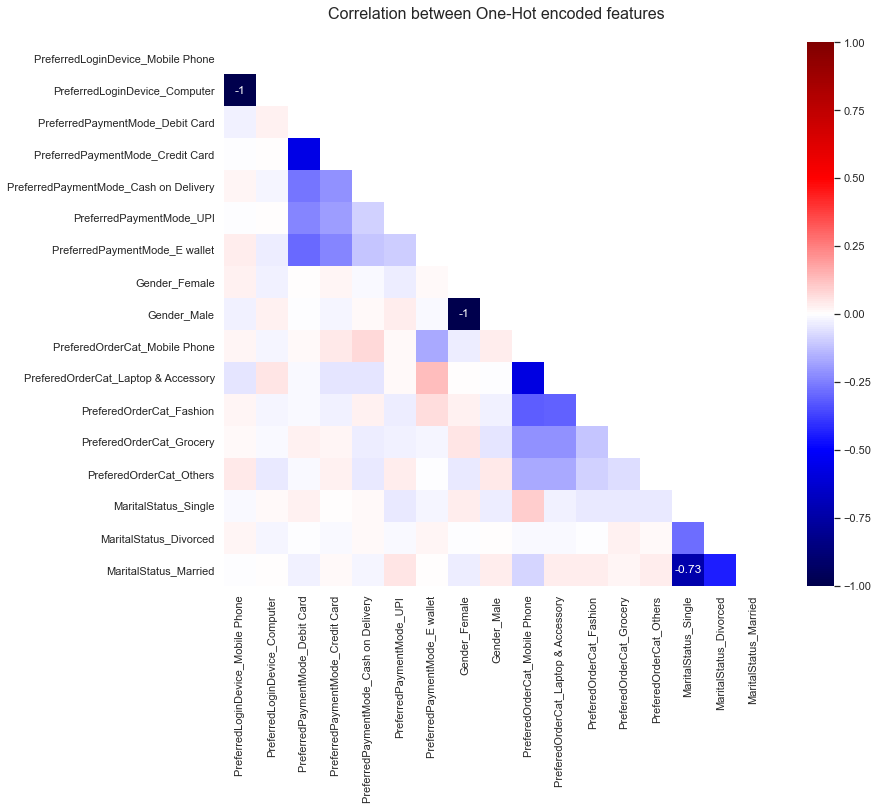

In [26]:
# Checking correlation between new features
corr = df_ohe.corr(method = 'spearman')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 10))
    ax = sns.heatmap(corr, mask=mask, annot = True, vmin = -1, vmax=1, square=True, cmap = 'seismic')
    for t in ax.texts:
        if abs(float(t.get_text()))>=0.7:
            t.set_text(t.get_text()) 
        else:
            t.set_text("")
plt.title('Correlation between One-Hot encoded features\n', size = 16)
plt.show()

In [27]:
drop_corr = DropCorrelatedFeatures(method = 'spearman', threshold = 0.99)
drop_corr.fit(df_ohe)
df_ohe = drop_corr.transform(df_ohe)

### Merge cat & num variables

In [28]:
X_train = X_train[num_vars].merge(df_ohe, left_index=True, right_index=True, how='inner')
X_train.head()

,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice_Mobile Phone,PreferredPaymentMode_Debit Card,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Cash on Delivery,PreferredPaymentMode_UPI,PreferredPaymentMode_E wallet,Gender_Female,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Others,MaritalStatus_Single,MaritalStatus_Divorced,MaritalStatus_Married
4478,1.00,1,2.48,3.00,4,4,3,1,13.00,1.00,2.00,3.00,149.78,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0
3685,17.00,1,2.56,4.00,5,3,3,1,15.00,2.00,2.00,9.00,165.81,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0
731,0.00,1,2.20,2.93,4,3,2,0,12.00,0.00,1.00,2.00,130.33,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0
291,10.20,1,2.08,2.00,3,2,2,1,23.00,1.00,1.00,0.00,117.02,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
184,4.00,1,2.40,2.00,3,2,1,1,12.00,0.00,1.00,3.00,148.21,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0


## Why Do People Complain?

In [29]:
X_train.groupby('Complain').mean()

,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice_Mobile Phone,PreferredPaymentMode_Debit Card,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Cash on Delivery,PreferredPaymentMode_UPI,PreferredPaymentMode_E wallet,Gender_Female,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Others,MaritalStatus_Single,MaritalStatus_Divorced,MaritalStatus_Married
Complain,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,10.36,1.66,2.61,2.94,3.69,3.10,4.27,15.75,1.78,3.06,4.62,177.18,0.71,0.41,0.31,0.10,0.07,0.11,0.38,0.37,0.37,0.14,0.07,0.05,0.32,0.15,0.54
1,9.81,1.66,2.66,2.92,3.70,2.97,4.03,15.71,1.74,2.94,4.24,177.08,0.71,0.40,0.31,0.09,0.09,0.11,0.42,0.38,0.35,0.15,0.07,0.05,0.32,0.16,0.52


There does not seem to be any major difference on average between the features with respect to the whether the person has complained.

# Scaling data

In [30]:
# fit scaler
rsc = RobustScaler()
rsc.fit(X_train)

# transform & new df
temp_df = rsc.transform(X_train)
X_train = pd.DataFrame(temp_df, columns = X_train.columns)
X_train.head()

,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice_Mobile Phone,PreferredPaymentMode_Debit Card,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Cash on Delivery,PreferredPaymentMode_UPI,PreferredPaymentMode_E wallet,Gender_Female,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Others,MaritalStatus_Single,MaritalStatus_Divorced,MaritalStatus_Married
0,-0.67,0.00,-0.19,0.00,0.00,0.50,0.00,1.00,-0.40,0.00,0.00,0.00,-0.28,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,-1.00
1,0.67,0.00,-0.09,1.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.20,0.04,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,-1.00
2,-0.75,0.00,-0.55,-0.07,0.00,0.00,-0.25,0.00,-0.60,-1.00,-0.49,-0.20,-0.67,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,-1.00
3,0.10,0.00,-0.70,-1.00,-1.00,-0.50,-0.25,1.00,1.60,0.00,-0.49,-0.60,-0.93,-1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,-1.00
4,-0.42,0.00,-0.30,-1.00,-1.00,-0.50,-0.50,1.00,-0.60,-1.00,-0.49,0.00,-0.31,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,-1.00


# Dealing with imbalance

## Oversampling w/ SMOTE

In [31]:
y_train.value_counts()

Churn
0        3741
1         763
dtype: int64

In [32]:
sm = SMOTE(random_state = 42)

# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = sm.fit_resample(X_train, 
                                                         y_train)

resampled_df = pd.concat([pd.DataFrame(oversampled_trainY), 
                          pd.DataFrame(oversampled_trainX)],
                         axis=1)
resampled_df.Churn.value_counts()

0    3741
1    3741
Name: Churn, dtype: int64

# Export training set for modelling

In [33]:
resampled_df.to_csv('train_churndata_preprocessed.csv', index = False)